In [1]:
# check chainer info
import chainer
chainer.print_runtime_info()

Platform: Linux-4.15.0-36-generic-x86_64-with-debian-stretch-sid
Chainer: 5.0.0
NumPy: 1.13.3
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 9000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : None
iDeep: Not Available


In [1]:
# setting datasets
from chainer.datasets import mnist

train_val, test = mnist.get_mnist(withlabel=True, ndim=1)

label: 5


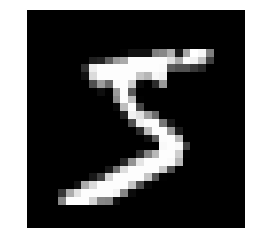

In [20]:
# display data
%matplotlib inline
import matplotlib.pyplot as plt

x, t = train_val[0] # (data, label)
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show
print('label:', t)

In [3]:
# divide data, Training and Validation
from chainer.datasets import split_dataset_random
train, valid = split_dataset_random(train_val, 50000, seed=0) # seed値でランダムな値を固定
print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))
print('test dataset size:', len(test))

Training dataset size: 50000
Validation dataset size: 10000
test dataset size: 10000


In [4]:
# minibatch processing
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(
    valid,
    batchsize,
    repeat=False,
    shuffle=False
)
test_iter = iterators.SerialIterator(
    test,
    batchsize,
    repeat=False,
    shuffle=False,
)

In [5]:
# Result guarantee
# より厳密なのはchainer.config.cudnn_deterministic
import random
import numpy
import chainer

def reset_seed(seed=0):
    random.seed(seed)
    numpy.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed(0)

In [6]:
# make neuralnetwork Link and Function (model)
import chainer.links as L # パラメータを持つ関数
import chainer.functions as F # パラメータを持たない関数
import chainer
class MLP(chainer.Chain):
    
    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        
        # パラメータを持つ層の登録
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units) # None, 100 : Noneはその時の入力でユニット数を計算する
            self.l2 = L.Linear(n_mid_units, n_mid_units) # 100, 100
            self.l3 = L.Linear(n_mid_units, n_out) # 100, 10
    
    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)
    
gpu_id = 0 # 0: gpu -1: cpu

net = MLP()

if gpu_id == 0:
    net.to_gpu(gpu_id)

In [7]:
# 重み行列: W バイアス: b
print('1つ目の全結合層のバイアスパラメータは :', net.l1.b.shape)
print('初期化直後の配列\n', net.l1.b.array)
print('2つ目の全結合層のバイアスパラメータは :', net.l2.b.shape)
print('初期化直後の配列\n', net.l2.b.array)
print('3つ目の全結合層のバイアスパラメータは :', net.l3.b.shape)
print('初期化直後の配列\n', net.l3.b.array)

1つ目の全結合層のバイアスパラメータは : (100,)
初期化直後の配列
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2つ目の全結合層のバイアスパラメータは : (100,)
初期化直後の配列
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3つ目の全結合層のバイアスパラメータは : (10,)
初期化直後の配列
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [8]:
#　まだ学習をしていないから重み行列(W)はNone
print("l1\n",net.l1.W.array) # None

l1
 None


In [9]:
# select Optimizer
# 訓練データの最適化手法を考える
# SGD(勾配降下法), MomentSGD, RMSprop, Adamとかいろいろあるよ
from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01).setup(net) # lr(learning late) ハイパーパラメータ

In [10]:
# learing
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:
    
    # --- 学習の1イテレーション ---
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch, gpu_id)
    
    # 予測計算
    y = net(x)
    
    # lossの計算
    loss = F.softmax_cross_entropy(y, t)
    
    # 勾配の計算
    net.cleargrads()
    loss.backward()
    
    # パラメータの更新
    optimizer.update()
    # --- ここまで ---
    
    # 1エポック終了ごとにValidationデータに対する予測精度を測って
    # モデルの汎用性が向上しているかのチェックを行う
    if train_iter.is_new_epoch: # 1epoch終了時
        
        # lossの表示
        print('epoch:{:02d} train_loss:{:.04f}'.format(train_iter.epoch, float(to_cpu(loss.data))), end=' ')
        
        valid_losses = []
        valid_accuracies = []
        while True:
            valid_batch = valid_iter.next()
            x_valid, t_valid = concat_examples(valid_batch, gpu_id)
            
            # Validationデータをforward
            with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
                y_valid = net(x_valid)
                
            # lossを計算
            loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
            valid_losses.append(to_cpu(loss_valid.array))
            
            # 精度を計算
            accuracy = F.accuracy(y_valid, t_valid)
            accuracy.to_cpu()
            valid_accuracies.append(accuracy.array)
            
            if valid_iter.is_new_epoch:
                valid_iter.reset()
                break
        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(np.mean(valid_losses), np.mean(valid_accuracies)))

# テストデータでの評価
test_accuracies = []
while True:
    test_batch = test_iter.next()
    x_test, t_test = concat_examples(test_batch, gpu_id)

    # テストデータをforward
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_test = net(x_test)

    # 精度の計算
    accuracy = F.accuracy(y_test, t_test)
    accuracy.to_cpu()
    test_accuracies.append(accuracy.array)

    if test_iter.is_new_epoch:
        test_iter.reset()
        break
print('test_accuracy:{:.04f}'.format(np.mean(test_accuracies)))

epoch:01 train_loss:1.0355 val_loss:0.9722 val_accuracy:0.7996
epoch:02 train_loss:0.5380 val_loss:0.5329 val_accuracy:0.8648
epoch:03 train_loss:0.3999 val_loss:0.4227 val_accuracy:0.8848
epoch:04 train_loss:0.3331 val_loss:0.3739 val_accuracy:0.8942
epoch:05 train_loss:0.4580 val_loss:0.3453 val_accuracy:0.8996
epoch:06 train_loss:0.2479 val_loss:0.3272 val_accuracy:0.9069
epoch:07 train_loss:0.3300 val_loss:0.3108 val_accuracy:0.9116
epoch:08 train_loss:0.3807 val_loss:0.2989 val_accuracy:0.9145
epoch:09 train_loss:0.2981 val_loss:0.2884 val_accuracy:0.9173
epoch:10 train_loss:0.3213 val_loss:0.2800 val_accuracy:0.9205
test_accuracy:0.9230


In [13]:
# save model
from chainer import serializers
serializers.save_npz('my_mnist.model', net)

In [16]:
# 保存したモデルで推論する
infer_net = MLP()

serializers.load_npz('my_mnist.model', infer_net) # load model

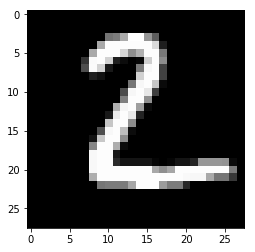

元の形 :  (784,) -> ミニバッチの形にしたあと :  (1, 784)
ネットワークの予測 :  2


In [25]:
# check model test
%matplotlib inline
import matplotlib.pyplot as plt

gpu_id = 0

if gpu_id >= 0:
    infer_net.to_gpu(gpu_id)

# 1つ目のテストデータを取り出す
x, t = test[1] # tは使わない

# 画像の表示
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()

# reshape minibatch
print('元の形 : ', x.shape, end = ' -> ')

x = x[None, ...]

print('ミニバッチの形にしたあと : ', x.shape)

# ネットワークと同じデバイス上にデータを送る
x = infer_net.xp.asarray(x)
#print('infer_net.xp.asarray(x) = ', x)

# モデルのforward関数に渡す
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = infer_net(x)
    
# Variable形式で出てくるため中身を取り出す
y = y.array

# 結果をCPUに送る
y = to_cpu(y)

# 予測確率の最大値インデックスを見る
pred_label = y.argmax(axis=1)

print('ネットワークの予測 : ', pred_label[0])